# Project setup

We will now start working with another abstraction layer: the training loop can be wrapped in a `Trainer` functor that takes care of loading data, defining epochs, logging, checkpointing, etc.

Layer types, loss and activation functions that are available in PyTorch can be found here: https://pytorch.org/docs/stable/nn.html

In [6]:
import sys, os, torch
import numpy as np

import matplotlib.pyplot as plt
import torch.utils.data as data
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import axes3d
from torch import optim, nn, utils, Tensor
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Lambda

import lightning as L
from pytorch_lightning.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
from torchview import draw_graph


sys.path.insert(1, '02_Lightning')
from Model_01 import *

Next, we load our data. The next tutorial step will go through the details of defining a dataloader, for now we just load a very common benchmark dataset from the internet.
We split the date in three parts: training, test and validation.
<ol>
<li>Training data is used to train the parameters of the model.</li>
<li>Validation data is used to optimize hyperparameters, sometimes between epochs</li>
<li>Test data is used to check for overfitting. When performance improves on training data but not test data, you are probably overfitting </li>
</ol>


It is possible to define custom dataloaders which can handle your data, we will skip this for now.
Below, we use some black magic to transform 28x28 images to vectors of length 784 on the fly. 
For real-world data you will do this as explicit as you like in an custom dataloader, that can handle loops.

Very often, the data is segmented into batches. This means the networks sees a couple of training instances at once. thios can dramatically influence training and prediction performance!

In [12]:
# configure torch
L.seed_everything(42)
torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision('medium')

# configure data
batch_size = 10

tf = Compose([ToTensor(), Lambda(torch.flatten)])
train_set = datasets.MNIST(root="MNIST", download=True, train=True, transform=tf)
test_set = datasets.MNIST(root="MNIST", download=True, train=False, transform=tf)

# use 20% of training data for validation
train_set_size = int(len(train_set) * 0.8)
val_set_size = len(train_set) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)

train_set, val_set = data.random_split(train_set, [train_set_size, val_set_size], generator=seed)
train_loader = utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=8, persistent_workers=True, shuffle=True)
test_loader = utils.data.DataLoader(test_set, batch_size=1, num_workers=8, persistent_workers=True, shuffle=False)
val_loader = utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=8, persistent_workers=True, shuffle=False)

Seed set to 42


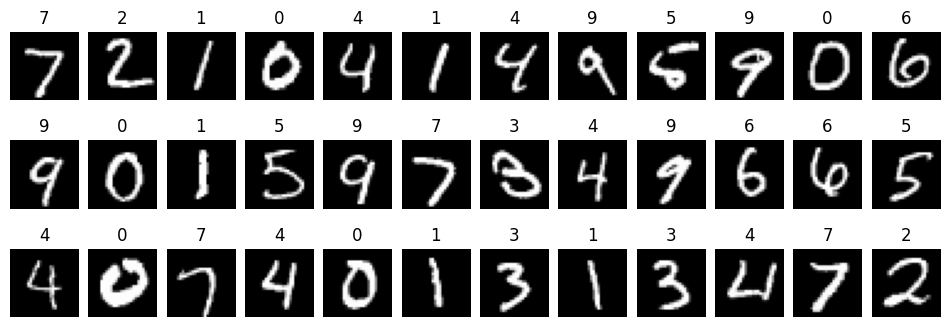

In [13]:
fig = plt.figure(figsize=(12, 10))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(3,12), 
                 axes_pad=(0.1,0.4), 
                 )
data_it = iter(test_loader)
for ax in grid:
    im, label = next(data_it)
    ax.imshow(im.reshape(28,28), cmap="gray")
    ax.set_title(label.item())
    ax.axis('off')

plt.show()

# Training

The next step is typically also done inside a dedicated script. For our testing purposes, we use this notebook.

Before running the training, you may want to start tensorboard via `tensorboard --logdir=lightning_logs` from the console in the root directory of this project.
This will allow you to access `http://localhost:6006/` in your browser and live view stats of the training.

Remember to change the device to cpu if you don't have an accelerator.


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
name = "Autoenc_01"
max_epochs = 5

model = AutoEncoder() 

lr_monitor = LearningRateMonitor(logging_interval='step')
early_stopping = EarlyStopping(monitor="val_loss",patience=40)
logger = TensorBoardLogger("lightning_logs", name=name)

# saved in `trainer.default_root_dir`/`logger.version`/`checkpoint_callback.dirpath`
val_ckeckpoint = ModelCheckpoint( 
                                filename="{epoch}-{step}-{val_loss:.8f}",
                                monitor="val_loss",
                                mode="min",
                                save_top_k=2,
                                save_last =True
                                )
callbacks = [val_ckeckpoint, lr_monitor, early_stopping] 
trainer = L.Trainer(enable_checkpointing=True, max_epochs=max_epochs, accelerator=device, callbacks=callbacks, logger=logger) 
# add ckpt_path="..." to restart from previous checkpoint (located in lightning_logs)
# OR resume_from_checkpoint="..." in Trainer
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Atomt\anaconda3\envs\myenv\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name       | Type       | Params
------------------------------------------
0 | activation | ReLU       | 0     
1 | loss       | MSELoss    | 0     
2 | encoder    | Sequential | 50.4 K
3 | decoder    | Sequential | 51.2 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Our model is now trained and we can test it.

If you want to resume training you can do so by providing the location of an automatically created checkpoint in the lightning_logs directory: `trainer.fit(model, ckpt_path="lightning_logs/version_N/my_checkpoint.ckpt")`

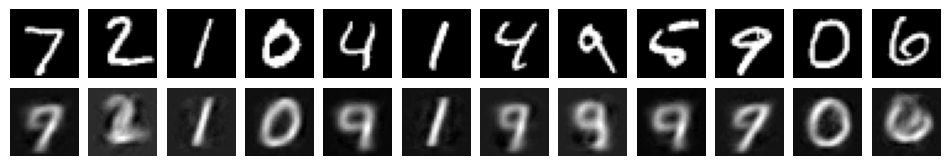

In [20]:
model.setup('predict')
model.to("cpu")
model.eval()

NTest = 12

fig = plt.figure(figsize=(12, 10))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2,NTest), 
                 axes_pad=(0.1,0.1), 
                 )
data_it = iter(test_loader)

images = []
images_compressed = []


for i in range(NTest):
    im, label = next(data_it)
    im_compressed = model(im).detach().numpy()
    pp = model.encoder(im).detach().numpy()
    images.append(im)
    images_compressed.append(im_compressed)

data_it = iter(test_loader)
vectors = dict(zip(range(10), [[] for _ in range(10)]))
for i in range(len(test_set)):
    im, label = next(data_it)
    im_compressed = model(im).detach().numpy()
    pp = model.encoder(im).detach().numpy()
    t = np.concatenate(([0, 0, 0],pp[0]), axis=0)
    vectors[label.item()].append(t)


plt_im = images + images_compressed
for ax, im in zip(grid, plt_im):
    ax.imshow(im.reshape(28,28), cmap="gray")
    #ax.set_title(label.item())
    ax.axis('off')

plt.show()


# Exercises

    - Try to adjust parameters above and see if you can improve speed during training without dropping the loss. A good start is the batch size, Another the optimizer and its settings.
    - run a couple of experiments and compare them in tensorboard.

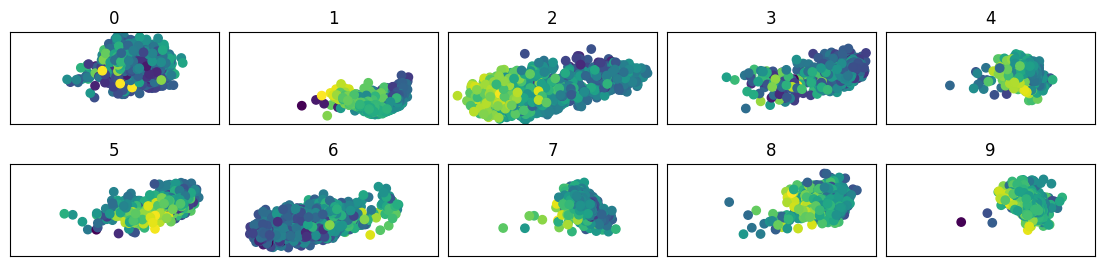

In [59]:
fig = plt.figure(figsize=(14, 16))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2,5), 
                 axes_pad=(0.1,0.4), 
                 share_all=True,
                 )
for ax, num in zip(grid, range(10)):
    vecs_np = np.array(vectors[num])
    ax.scatter(vecs_np[:,3] , vecs_np[:,4] , c = vecs_np[:,5])
    ax.set_title(num)
    ax.xlims=(-1,1)
    ax.ylims=(-1,1)
    ax.tick_params(left = False, right = False , labelleft = False, 
                    labelbottom = False, bottom = False) 
    #ax.axis('off')

plt.show()

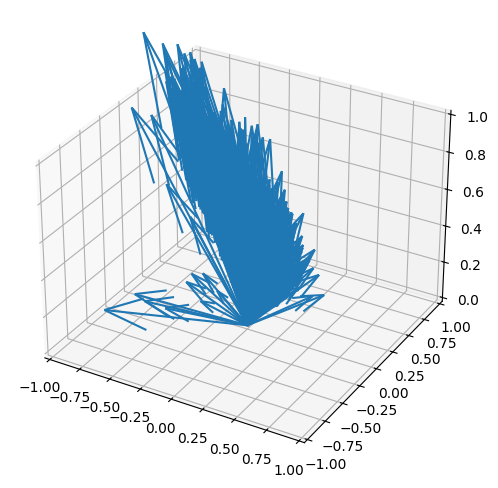

In [ ]:
number_to_plot = 1

soa = vectors[number_to_plot]
X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure( figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-1, 1.0])
ax.set_ylim([-1, 1.0])
ax.set_zlim([0, 1.0])
plt.show()